In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
import pandas as pd
from PIL import Image
from scipy.stats import pearsonr
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torchvision.models as models
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import torchvision.models as models
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
import pandas as pd
from PIL import Image
from scipy.stats import pearsonr
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision.models as models
from typing import Any
from typing import List

/apps/local/shared/HC701/hc701_env/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


**DeepLabV3 with SE and pre-processed images**

In [12]:
class SELayer(nn.Module):
    def __init__(self, channel, reduction=16):
        super(SELayer, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channel, channel // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channel // reduction, channel, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y

class UNetDeeplab(nn.Module):
    def __init__(self, input_channel, output_channel):
        super(UNetDeeplab, self).__init__()

        self.model = models.segmentation.deeplabv3_resnet50(pretrained=True)

        if input_channel != 3:
            self.model.backbone.conv1 = nn.Conv2d(input_channel, 64, kernel_size=7, stride=2, padding=3, bias=False)

        self.model.classifier[4] = nn.Conv2d(256, output_channel, kernel_size=1, stride=1)

        for m in self.model.backbone.modules():
            if isinstance(m, models.resnet.Bottleneck):
                m.conv3 = nn.Sequential(m.conv3, SELayer(m.conv3.out_channels))

    def forward(self, x):
        features = self.model(x)['out']
        return features

In [29]:
class CustomDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.data = pd.read_csv(csv_file)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name = self.data.iloc[idx, 0]
        mask_name = self.data.iloc[idx, 1]
        image = Image.open(img_name).convert('RGB')
        mask = Image.open(mask_name).convert('L')
        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        mask = (mask > 0.5).float()

        return image, mask

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

train_csv_file = "/home/maitha.alnaqbi/Desktop/ai702_project/Coronary/train/train_data_with_filter.csv"
test_csv_file = "/home/maitha.alnaqbi/Desktop/ai702_project/Coronary/test/test_data.csv"

train_dataset = CustomDataset(train_csv_file, transform=transform)
test_dataset = CustomDataset(test_csv_file, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False, drop_last=True)

val_csv_file = "/home/maitha.alnaqbi/Desktop/ai702_project/Coronary/val/val_data.csv"
val_dataset = CustomDataset(val_csv_file, transform=transform)
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False)

In [14]:
print("Train Loader:")
for images, masks in train_loader:
    print("Image Shape:", images.shape)
    print("Mask Shape:", masks.shape)
    break
print("Length of Train Loader:", len(train_loader))

print("\nTest Loader:")
for images, masks in test_loader:
    print("Image Shape:", images.shape)
    print("Mask Shape:", masks.shape)
    break
print("Length of Test Loader:", len(test_loader))

print("\nValidation Loader:")
for images, masks in val_loader:
    print("Image Shape:", images.shape)
    print("Mask Shape:", masks.shape)
    break
print("Length of Validation Loader:", len(val_loader))

Train Loader:
Image Shape: torch.Size([2, 3, 256, 256])
Mask Shape: torch.Size([2, 1, 256, 256])
Length of Train Loader: 865

Test Loader:
Image Shape: torch.Size([2, 3, 256, 256])
Mask Shape: torch.Size([2, 1, 256, 256])
Length of Test Loader: 130

Validation Loader:
Image Shape: torch.Size([2, 3, 256, 256])
Mask Shape: torch.Size([2, 1, 256, 256])
Length of Validation Loader: 90


In [ ]:
def dice_coeff(pred, target):
    smooth = 1.0
    intersection = (pred * target).sum()
    return (2. * intersection + smooth) / (pred.sum() + target.sum() + smooth)

def iou(pred, target):
    pred = pred.bool() 
    target = target.bool()
    intersection = (pred & target).sum((1, 2))
    union = (pred | target).sum((1, 2))
    iou = (intersection + 1e-6) / (union + 1e-6)
    return iou.mean()

/apps/local/shared/HC701/hc701_env/lib/python3.8/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Epoch 1/100, Train Loss: 0.1263, Val Loss: 0.2670, Mean Dice: 0.0518, Mean IoU: 0.8177, Pearson Correlation: 0.0748
Epoch 2/100, Train Loss: 0.0367, Val Loss: 0.0557, Mean Dice: 0.0076, Mean IoU: 0.8145, Pearson Correlation: 0.0204
Epoch 3/100, Train Loss: 0.0270, Val Loss: 0.0377, Mean Dice: 0.1182, Mean IoU: 0.8155, Pearson Correlation: 0.1702
Epoch 4/100, Train Loss: 0.0232, Val Loss: 0.0825, Mean Dice: 0.2125, Mean IoU: 0.8169, Pearson Correlation: 0.2600
Epoch 5/100, Train Loss: 0.0251, Val Loss: 0.0297, Mean Dice: 0.0738, Mean IoU: 0.8146, Pearson Correlation: 0.1287
Epoch 6/100, Train Loss: 0.0225, Val Loss: 0.0269, Mean Dice: 0.1841, Mean IoU: 0.8169, Pearson Correlation: 0.2419
Epoch 7/100, Train Loss: 0.0201, Val Loss: 0.0284, Mean Dice: 0.2645, Mean IoU: 0.8108, Pearson Correlation: 0.3087
Epoch 8/100, Train Loss: 0.0188, Val Loss: 0.0276, Mean Dice: 0.3602, Mean IoU: 0.8100, Pearson Correlation: 0.3855
Epoch 9/100, Train Loss: 0.0175, Val Loss: 0.0799, Mean Dice: 0.2742, Me

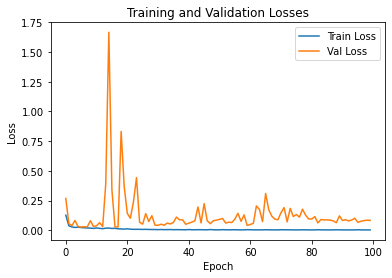

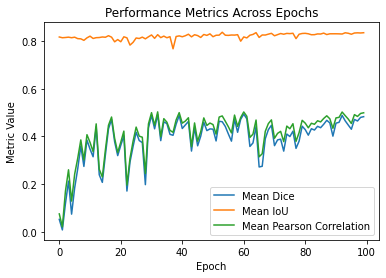

In [15]:

dev = "cuda" if torch.cuda.is_available() else "cpu"

model = UNetDeeplab(input_channel=3, output_channel=1).to(dev)
loss_function = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

train_losses = []
val_losses = []

mean_dice_scores = []
mean_iou_scores = []
mean_pearson_correlation = []

num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for batch_idx, (images, masks) in enumerate(train_loader):
        #print(f"Batch {batch_idx}, Input shape: {images.shape}")
        optimizer.zero_grad()
        outputs = model(images.to(dev))
        loss = loss_function(outputs, masks.to(dev))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_train_loss = total_loss / len(train_loader)
    train_losses.append(avg_train_loss)


    model.eval()
    total_val_loss = 0
    total_dice, total_iou, total_pearson = 0, 0, 0
    with torch.no_grad():
        for images, masks in test_loader:
            outputs = model(images.to(dev))
            val_loss = loss_function(outputs, masks.to(dev))
            total_val_loss += val_loss.item()
            
            outputs_thresh = torch.sigmoid(outputs) > 0.5
            total_dice += dice_coeff(outputs_thresh, masks.to(dev)).item()
            
            total_iou += iou(outputs_thresh, masks.to(dev)).mean().item()
            
            outputs_np = outputs_thresh.view(-1).cpu().numpy()
            masks_np = masks.view(-1).cpu().numpy()
            pearson_corr, _ = pearsonr(outputs_np, masks_np)
            if not np.isnan(pearson_corr):
                total_pearson += pearson_corr

    avg_val_loss = total_val_loss / len(test_loader)
    val_losses.append(avg_val_loss)

    avg_dice = total_dice / len(test_loader)
    mean_dice_scores.append(avg_dice)
    
    avg_iou = total_iou / len(test_loader)
    mean_iou_scores.append(avg_iou)
    
    avg_pearson = total_pearson / len(test_loader)
    mean_pearson_correlation.append(avg_pearson)

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Mean Dice: {avg_dice:.4f}, Mean IoU: {avg_iou:.4f}, Pearson Correlation: {avg_pearson:.4f}')

torch.save(model.state_dict(), 'SE_filter_deeplab50_with_bce_loss.pth')

plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.savefig('loss_plot.png')
plt.show()

plt.plot(mean_dice_scores, label='Mean Dice')
plt.plot(mean_iou_scores, label='Mean IoU')
plt.plot(mean_pearson_correlation, label='Mean Pearson Correlation')
plt.xlabel('Epoch')
plt.ylabel('Metric Value')
plt.title('Performance Metrics Across Epochs')
plt.legend()
plt.savefig('performance_metrics_plot.png')
plt.show()

**Experiments**

1- Change learning rate (from 1e-4 to 1e-3)

Epoch 1/100, Train Loss: 0.0451, Val Loss: 0.0830, Mean Dice: 0.0010, Mean IoU: 0.8148, Pearson Correlation: 0.0000
Epoch 2/100, Train Loss: 0.0267, Val Loss: 0.0330, Mean Dice: 0.0056, Mean IoU: 0.8146, Pearson Correlation: 0.0193
Epoch 3/100, Train Loss: 0.0241, Val Loss: 0.0288, Mean Dice: 0.0054, Mean IoU: 0.8147, Pearson Correlation: 0.0206
Epoch 4/100, Train Loss: 0.0226, Val Loss: 0.0506, Mean Dice: 0.0115, Mean IoU: 0.8142, Pearson Correlation: 0.0413
Epoch 5/100, Train Loss: 0.0219, Val Loss: 0.0263, Mean Dice: 0.1348, Mean IoU: 0.8079, Pearson Correlation: 0.1973
Epoch 6/100, Train Loss: 0.0211, Val Loss: 0.0399, Mean Dice: 0.1075, Mean IoU: 0.8084, Pearson Correlation: 0.1601
Epoch 7/100, Train Loss: 0.0202, Val Loss: 0.0251, Mean Dice: 0.2948, Mean IoU: 0.8157, Pearson Correlation: 0.3333
Epoch 8/100, Train Loss: 0.0192, Val Loss: 0.0252, Mean Dice: 0.3132, Mean IoU: 0.8212, Pearson Correlation: 0.3614
Epoch 9/100, Train Loss: 0.0180, Val Loss: 0.0242, Mean Dice: 0.4053, Me

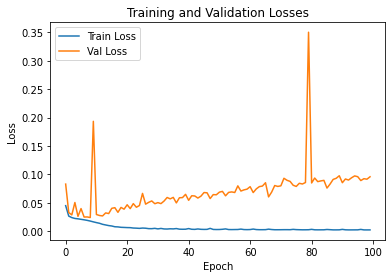

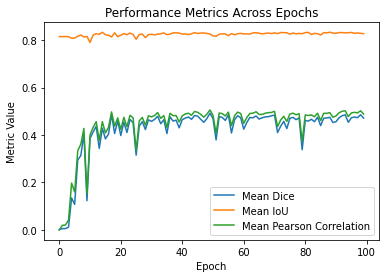

In [16]:

dev = "cuda" if torch.cuda.is_available() else "cpu"

model = UNetDeeplab(input_channel=3, output_channel=1).to(dev)
loss_function = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

train_losses = []
val_losses = []

mean_dice_scores = []
mean_iou_scores = []
mean_pearson_correlation = []

num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for batch_idx, (images, masks) in enumerate(train_loader):
        #print(f"Batch {batch_idx}, Input shape: {images.shape}")
        optimizer.zero_grad()
        outputs = model(images.to(dev))
        loss = loss_function(outputs, masks.to(dev))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_train_loss = total_loss / len(train_loader)
    train_losses.append(avg_train_loss)


    model.eval()
    total_val_loss = 0
    total_dice, total_iou, total_pearson = 0, 0, 0
    with torch.no_grad():
        for images, masks in test_loader:
            outputs = model(images.to(dev))
            val_loss = loss_function(outputs, masks.to(dev))
            total_val_loss += val_loss.item()
            
            outputs_thresh = torch.sigmoid(outputs) > 0.5
            total_dice += dice_coeff(outputs_thresh, masks.to(dev)).item()
            
            total_iou += iou(outputs_thresh, masks.to(dev)).mean().item()
            
            outputs_np = outputs_thresh.view(-1).cpu().numpy()
            masks_np = masks.view(-1).cpu().numpy()
            pearson_corr, _ = pearsonr(outputs_np, masks_np)
            if not np.isnan(pearson_corr):
                total_pearson += pearson_corr

    avg_val_loss = total_val_loss / len(test_loader)
    val_losses.append(avg_val_loss)

    avg_dice = total_dice / len(test_loader)
    mean_dice_scores.append(avg_dice)
    
    avg_iou = total_iou / len(test_loader)
    mean_iou_scores.append(avg_iou)
    
    avg_pearson = total_pearson / len(test_loader)
    mean_pearson_correlation.append(avg_pearson)

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Mean Dice: {avg_dice:.4f}, Mean IoU: {avg_iou:.4f}, Pearson Correlation: {avg_pearson:.4f}')

torch.save(model.state_dict(), 'SE_filter_deeplab50_with_bce_loss_learningrate1.pth')

plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.savefig('loss_plot.png')
plt.show()

plt.plot(mean_dice_scores, label='Mean Dice')
plt.plot(mean_iou_scores, label='Mean IoU')
plt.plot(mean_pearson_correlation, label='Mean Pearson Correlation')
plt.xlabel('Epoch')
plt.ylabel('Metric Value')
plt.title('Performance Metrics Across Epochs')
plt.legend()
plt.savefig('performance_metrics_plot.png')
plt.show()

2- Batchsize (with 1e-4) train to 8

In [17]:
class CustomDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.data = pd.read_csv(csv_file)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name = self.data.iloc[idx, 0]
        mask_name = self.data.iloc[idx, 1]
        image = Image.open(img_name).convert('RGB')
        mask = Image.open(mask_name).convert('L')
        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        mask = (mask > 0.5).float()

        return image, mask

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

train_csv_file = "/home/maitha.alnaqbi/Desktop/ai702_project/Coronary/train/train_data_with_filter.csv"
test_csv_file = "/home/maitha.alnaqbi/Desktop/ai702_project/Coronary/test/test_data.csv"

train_dataset = CustomDataset(train_csv_file, transform=transform)
test_dataset = CustomDataset(test_csv_file, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False, drop_last=True)

val_csv_file = "/home/maitha.alnaqbi/Desktop/ai702_project/Coronary/val/val_data.csv"
val_dataset = CustomDataset(val_csv_file, transform=transform)
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False)

Epoch 1/100, Train Loss: 0.0786, Val Loss: 0.0366, Mean Dice: 0.0010, Mean IoU: 0.8148, Pearson Correlation: 0.0000
Epoch 2/100, Train Loss: 0.0266, Val Loss: 0.0278, Mean Dice: 0.1164, Mean IoU: 0.8163, Pearson Correlation: 0.1670
Epoch 3/100, Train Loss: 0.0226, Val Loss: 0.0260, Mean Dice: 0.2209, Mean IoU: 0.8083, Pearson Correlation: 0.2707
Epoch 4/100, Train Loss: 0.0203, Val Loss: 0.0279, Mean Dice: 0.2179, Mean IoU: 0.8110, Pearson Correlation: 0.2691
Epoch 5/100, Train Loss: 0.0181, Val Loss: 0.0260, Mean Dice: 0.2982, Mean IoU: 0.8140, Pearson Correlation: 0.3481
Epoch 6/100, Train Loss: 0.0160, Val Loss: 0.0268, Mean Dice: 0.3413, Mean IoU: 0.8183, Pearson Correlation: 0.3754
Epoch 7/100, Train Loss: 0.0146, Val Loss: 0.0257, Mean Dice: 0.4333, Mean IoU: 0.8090, Pearson Correlation: 0.4501
Epoch 8/100, Train Loss: 0.0128, Val Loss: 0.0262, Mean Dice: 0.4364, Mean IoU: 0.8314, Pearson Correlation: 0.4619
Epoch 9/100, Train Loss: 0.0113, Val Loss: 0.0254, Mean Dice: 0.4423, Me

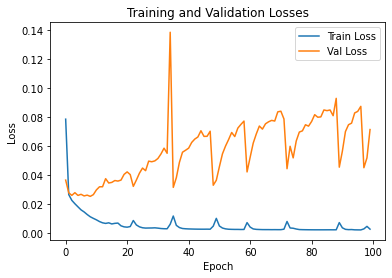

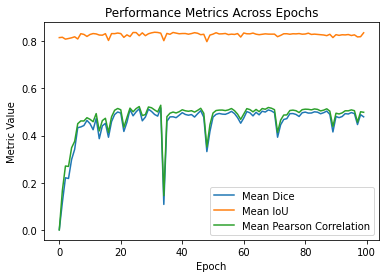

In [18]:


dev = "cuda" if torch.cuda.is_available() else "cpu"

model = UNetDeeplab(input_channel=3, output_channel=1).to(dev)
loss_function = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

train_losses = []
val_losses = []

mean_dice_scores = []
mean_iou_scores = []
mean_pearson_correlation = []

num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for batch_idx, (images, masks) in enumerate(train_loader):
        #print(f"Batch {batch_idx}, Input shape: {images.shape}")
        optimizer.zero_grad()
        outputs = model(images.to(dev))
        loss = loss_function(outputs, masks.to(dev))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_train_loss = total_loss / len(train_loader)
    train_losses.append(avg_train_loss)


    model.eval()
    total_val_loss = 0
    total_dice, total_iou, total_pearson = 0, 0, 0
    with torch.no_grad():
        for images, masks in test_loader:
            outputs = model(images.to(dev))
            val_loss = loss_function(outputs, masks.to(dev))
            total_val_loss += val_loss.item()
            
            outputs_thresh = torch.sigmoid(outputs) > 0.5
            total_dice += dice_coeff(outputs_thresh, masks.to(dev)).item()
            
            total_iou += iou(outputs_thresh, masks.to(dev)).mean().item()
            
            outputs_np = outputs_thresh.view(-1).cpu().numpy()
            masks_np = masks.view(-1).cpu().numpy()
            pearson_corr, _ = pearsonr(outputs_np, masks_np)
            if not np.isnan(pearson_corr):
                total_pearson += pearson_corr

    avg_val_loss = total_val_loss / len(test_loader)
    val_losses.append(avg_val_loss)

    avg_dice = total_dice / len(test_loader)
    mean_dice_scores.append(avg_dice)
    
    avg_iou = total_iou / len(test_loader)
    mean_iou_scores.append(avg_iou)
    
    avg_pearson = total_pearson / len(test_loader)
    mean_pearson_correlation.append(avg_pearson)

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Mean Dice: {avg_dice:.4f}, Mean IoU: {avg_iou:.4f}, Pearson Correlation: {avg_pearson:.4f}')

torch.save(model.state_dict(), 'SE_filter_deeplab50_with_bce_loss_batch8.pth')

plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.savefig('loss_plot.png')
plt.show()

plt.plot(mean_dice_scores, label='Mean Dice')
plt.plot(mean_iou_scores, label='Mean IoU')
plt.plot(mean_pearson_correlation, label='Mean Pearson Correlation')
plt.xlabel('Epoch')
plt.ylabel('Metric Value')
plt.title('Performance Metrics Across Epochs')
plt.legend()
plt.savefig('performance_metrics_plot.png')
plt.show()

3- Same as before but test batch to 1

In [19]:
#Discard this
class CustomDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.data = pd.read_csv(csv_file)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name = self.data.iloc[idx, 0]
        mask_name = self.data.iloc[idx, 1]
        image = Image.open(img_name).convert('RGB')
        mask = Image.open(mask_name).convert('L')
        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        mask = (mask > 0.5).float()

        return image, mask

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

train_csv_file = "/home/maitha.alnaqbi/Desktop/ai702_project/Coronary/train/train_data_with_filter.csv"
test_csv_file = "/home/maitha.alnaqbi/Desktop/ai702_project/Coronary/test/test_data.csv"

train_dataset = CustomDataset(train_csv_file, transform=transform)
test_dataset = CustomDataset(test_csv_file, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, drop_last=True)

val_csv_file = "/home/maitha.alnaqbi/Desktop/ai702_project/Coronary/val/val_data.csv"
val_dataset = CustomDataset(val_csv_file, transform=transform)
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False)

Epoch 1/100, Train Loss: 0.0695, Val Loss: 0.0317, Mean Dice: 0.0675, Mean IoU: 0.8033, Pearson Correlation: 0.1010
Epoch 2/100, Train Loss: 0.0248, Val Loss: 0.0317, Mean Dice: 0.0063, Mean IoU: 0.8147, Pearson Correlation: 0.0128
Epoch 3/100, Train Loss: 0.0212, Val Loss: 0.0280, Mean Dice: 0.1760, Mean IoU: 0.8170, Pearson Correlation: 0.2134
Epoch 4/100, Train Loss: 0.0184, Val Loss: 0.0261, Mean Dice: 0.3413, Mean IoU: 0.8075, Pearson Correlation: 0.3725
Epoch 5/100, Train Loss: 0.0163, Val Loss: 0.0266, Mean Dice: 0.2851, Mean IoU: 0.8237, Pearson Correlation: 0.3245
Epoch 6/100, Train Loss: 0.0144, Val Loss: 0.0309, Mean Dice: 0.2147, Mean IoU: 0.8229, Pearson Correlation: 0.2654
Epoch 7/100, Train Loss: 0.0124, Val Loss: 0.0243, Mean Dice: 0.4431, Mean IoU: 0.8185, Pearson Correlation: 0.4662
Epoch 8/100, Train Loss: 0.0108, Val Loss: 0.0279, Mean Dice: 0.4415, Mean IoU: 0.7822, Pearson Correlation: 0.4578
Epoch 9/100, Train Loss: 0.0097, Val Loss: 0.0262, Mean Dice: 0.4800, Me

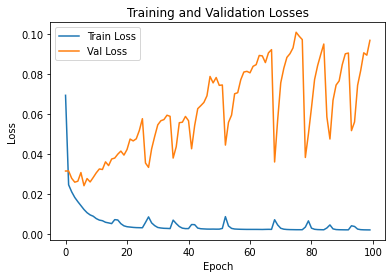

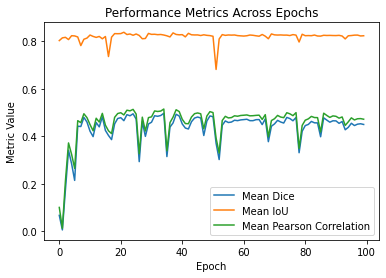

In [20]:
#discard this
dev = "cuda" if torch.cuda.is_available() else "cpu"

model = UNetDeeplab(input_channel=3, output_channel=1).to(dev)
loss_function = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

train_losses = []
val_losses = []

mean_dice_scores = []
mean_iou_scores = []
mean_pearson_correlation = []

num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for batch_idx, (images, masks) in enumerate(train_loader):
        #print(f"Batch {batch_idx}, Input shape: {images.shape}")
        optimizer.zero_grad()
        outputs = model(images.to(dev))
        loss = loss_function(outputs, masks.to(dev))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_train_loss = total_loss / len(train_loader)
    train_losses.append(avg_train_loss)


    model.eval()
    total_val_loss = 0
    total_dice, total_iou, total_pearson = 0, 0, 0
    with torch.no_grad():
        for images, masks in test_loader:
            outputs = model(images.to(dev))
            val_loss = loss_function(outputs, masks.to(dev))
            total_val_loss += val_loss.item()
            
            outputs_thresh = torch.sigmoid(outputs) > 0.5
            total_dice += dice_coeff(outputs_thresh, masks.to(dev)).item()
            
            total_iou += iou(outputs_thresh, masks.to(dev)).mean().item()
            
            outputs_np = outputs_thresh.view(-1).cpu().numpy()
            masks_np = masks.view(-1).cpu().numpy()
            pearson_corr, _ = pearsonr(outputs_np, masks_np)
            if not np.isnan(pearson_corr):
                total_pearson += pearson_corr

    avg_val_loss = total_val_loss / len(test_loader)
    val_losses.append(avg_val_loss)

    avg_dice = total_dice / len(test_loader)
    mean_dice_scores.append(avg_dice)
    
    avg_iou = total_iou / len(test_loader)
    mean_iou_scores.append(avg_iou)
    
    avg_pearson = total_pearson / len(test_loader)
    mean_pearson_correlation.append(avg_pearson)

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Mean Dice: {avg_dice:.4f}, Mean IoU: {avg_iou:.4f}, Pearson Correlation: {avg_pearson:.4f}')

torch.save(model.state_dict(), 'SE_filter_deeplab50_with_bce_loss_batch8_test1.pth')

plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.savefig('loss_plot.png')
plt.show()

plt.plot(mean_dice_scores, label='Mean Dice')
plt.plot(mean_iou_scores, label='Mean IoU')
plt.plot(mean_pearson_correlation, label='Mean Pearson Correlation')
plt.xlabel('Epoch')
plt.ylabel('Metric Value')
plt.title('Performance Metrics Across Epochs')
plt.legend()
plt.savefig('performance_metrics_plot.png')
plt.show()

4- learning rate 1e-5

Epoch 1/100, Train Loss: 0.3790, Val Loss: 0.3044, Mean Dice: 0.0009, Mean IoU: 0.8110, Pearson Correlation: -0.0004
Epoch 2/100, Train Loss: 0.2081, Val Loss: 0.2347, Mean Dice: 0.0009, Mean IoU: 0.8127, Pearson Correlation: -0.0003
Epoch 3/100, Train Loss: 0.1440, Val Loss: 0.1359, Mean Dice: 0.0009, Mean IoU: 0.8125, Pearson Correlation: -0.0003
Epoch 4/100, Train Loss: 0.1032, Val Loss: 0.0951, Mean Dice: 0.0020, Mean IoU: 0.8092, Pearson Correlation: 0.0017
Epoch 5/100, Train Loss: 0.0771, Val Loss: 0.0851, Mean Dice: 0.0069, Mean IoU: 0.8100, Pearson Correlation: 0.0113
Epoch 6/100, Train Loss: 0.0595, Val Loss: 0.0789, Mean Dice: 0.0810, Mean IoU: 0.8136, Pearson Correlation: 0.1047
Epoch 7/100, Train Loss: 0.0477, Val Loss: 0.0667, Mean Dice: 0.0733, Mean IoU: 0.8108, Pearson Correlation: 0.0963
Epoch 8/100, Train Loss: 0.0387, Val Loss: 0.0631, Mean Dice: 0.2305, Mean IoU: 0.8164, Pearson Correlation: 0.2618
Epoch 9/100, Train Loss: 0.0323, Val Loss: 0.0473, Mean Dice: 0.1804,

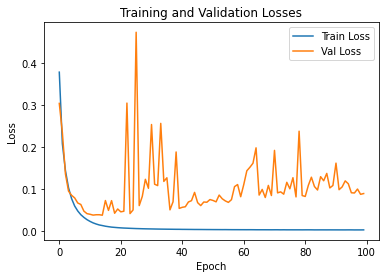

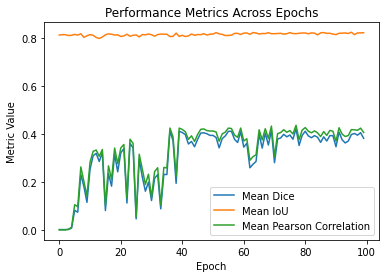

In [23]:


dev = "cuda" if torch.cuda.is_available() else "cpu"

model = UNetDeeplab(input_channel=3, output_channel=1).to(dev)
loss_function = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-5)

train_losses = []
val_losses = []

mean_dice_scores = []
mean_iou_scores = []
mean_pearson_correlation = []

num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for batch_idx, (images, masks) in enumerate(train_loader):
        #print(f"Batch {batch_idx}, Input shape: {images.shape}")
        optimizer.zero_grad()
        outputs = model(images.to(dev))
        loss = loss_function(outputs, masks.to(dev))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_train_loss = total_loss / len(train_loader)
    train_losses.append(avg_train_loss)


    model.eval()
    total_val_loss = 0
    total_dice, total_iou, total_pearson = 0, 0, 0
    with torch.no_grad():
        for images, masks in test_loader:
            outputs = model(images.to(dev))
            val_loss = loss_function(outputs, masks.to(dev))
            total_val_loss += val_loss.item()
            
            outputs_thresh = torch.sigmoid(outputs) > 0.5
            total_dice += dice_coeff(outputs_thresh, masks.to(dev)).item()
            
            total_iou += iou(outputs_thresh, masks.to(dev)).mean().item()
            
            outputs_np = outputs_thresh.view(-1).cpu().numpy()
            masks_np = masks.view(-1).cpu().numpy()
            pearson_corr, _ = pearsonr(outputs_np, masks_np)
            if not np.isnan(pearson_corr):
                total_pearson += pearson_corr

    avg_val_loss = total_val_loss / len(test_loader)
    val_losses.append(avg_val_loss)

    avg_dice = total_dice / len(test_loader)
    mean_dice_scores.append(avg_dice)
    
    avg_iou = total_iou / len(test_loader)
    mean_iou_scores.append(avg_iou)
    
    avg_pearson = total_pearson / len(test_loader)
    mean_pearson_correlation.append(avg_pearson)

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Mean Dice: {avg_dice:.4f}, Mean IoU: {avg_iou:.4f}, Pearson Correlation: {avg_pearson:.4f}')

torch.save(model.state_dict(), 'SE_filter_deeplab50_with_bce_loss_learningrate2.pth')

plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.savefig('loss_plot.png')
plt.show()

plt.plot(mean_dice_scores, label='Mean Dice')
plt.plot(mean_iou_scores, label='Mean IoU')
plt.plot(mean_pearson_correlation, label='Mean Pearson Correlation')
plt.xlabel('Epoch')
plt.ylabel('Metric Value')
plt.title('Performance Metrics Across Epochs')
plt.legend()
plt.savefig('performance_metrics_plot.png')
plt.show()

5- learning rate 1e-2

Epoch 1/100, Train Loss: 0.0346, Val Loss: 0.0434, Mean Dice: 0.0010, Mean IoU: 0.8148, Pearson Correlation: 0.0000
Epoch 2/100, Train Loss: 0.0266, Val Loss: 0.0371, Mean Dice: 0.0010, Mean IoU: 0.8148, Pearson Correlation: 0.0000
Epoch 3/100, Train Loss: 0.0247, Val Loss: 0.0275, Mean Dice: 0.0010, Mean IoU: 0.8148, Pearson Correlation: 0.0000
Epoch 4/100, Train Loss: 0.0248, Val Loss: 0.0353, Mean Dice: 0.0010, Mean IoU: 0.8148, Pearson Correlation: 0.0000
Epoch 5/100, Train Loss: 0.0258, Val Loss: 0.0312, Mean Dice: 0.0010, Mean IoU: 0.8148, Pearson Correlation: 0.0000
Epoch 6/100, Train Loss: 0.0241, Val Loss: 0.0293, Mean Dice: 0.0015, Mean IoU: 0.8148, Pearson Correlation: 0.0046
Epoch 7/100, Train Loss: 0.0225, Val Loss: 0.0282, Mean Dice: 0.0913, Mean IoU: 0.8109, Pearson Correlation: 0.1417
Epoch 8/100, Train Loss: 0.0224, Val Loss: 0.0273, Mean Dice: 0.1179, Mean IoU: 0.8124, Pearson Correlation: 0.1764
Epoch 9/100, Train Loss: 0.0217, Val Loss: 0.0264, Mean Dice: 0.1968, Me

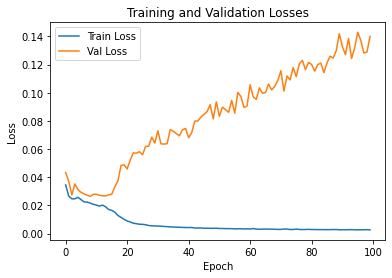

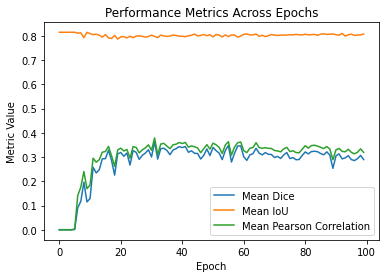

In [24]:


dev = "cuda" if torch.cuda.is_available() else "cpu"

model = UNetDeeplab(input_channel=3, output_channel=1).to(dev)
loss_function = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-2)

train_losses = []
val_losses = []

mean_dice_scores = []
mean_iou_scores = []
mean_pearson_correlation = []

num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for batch_idx, (images, masks) in enumerate(train_loader):
        #print(f"Batch {batch_idx}, Input shape: {images.shape}")
        optimizer.zero_grad()
        outputs = model(images.to(dev))
        loss = loss_function(outputs, masks.to(dev))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_train_loss = total_loss / len(train_loader)
    train_losses.append(avg_train_loss)


    model.eval()
    total_val_loss = 0
    total_dice, total_iou, total_pearson = 0, 0, 0
    with torch.no_grad():
        for images, masks in test_loader:
            outputs = model(images.to(dev))
            val_loss = loss_function(outputs, masks.to(dev))
            total_val_loss += val_loss.item()
            
            outputs_thresh = torch.sigmoid(outputs) > 0.5
            total_dice += dice_coeff(outputs_thresh, masks.to(dev)).item()
            
            total_iou += iou(outputs_thresh, masks.to(dev)).mean().item()
            
            outputs_np = outputs_thresh.view(-1).cpu().numpy()
            masks_np = masks.view(-1).cpu().numpy()
            pearson_corr, _ = pearsonr(outputs_np, masks_np)
            if not np.isnan(pearson_corr):
                total_pearson += pearson_corr

    avg_val_loss = total_val_loss / len(test_loader)
    val_losses.append(avg_val_loss)

    avg_dice = total_dice / len(test_loader)
    mean_dice_scores.append(avg_dice)
    
    avg_iou = total_iou / len(test_loader)
    mean_iou_scores.append(avg_iou)
    
    avg_pearson = total_pearson / len(test_loader)
    mean_pearson_correlation.append(avg_pearson)

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Mean Dice: {avg_dice:.4f}, Mean IoU: {avg_iou:.4f}, Pearson Correlation: {avg_pearson:.4f}')

torch.save(model.state_dict(), 'SE_filter_deeplab50_with_bce_loss_learningrate3.pth')

plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.savefig('loss_plot.png')
plt.show()

plt.plot(mean_dice_scores, label='Mean Dice')
plt.plot(mean_iou_scores, label='Mean IoU')
plt.plot(mean_pearson_correlation, label='Mean Pearson Correlation')
plt.xlabel('Epoch')
plt.ylabel('Metric Value')
plt.title('Performance Metrics Across Epochs')
plt.legend()
plt.savefig('performance_metrics_plot.png')
plt.show()

6- learning rate 1e-4 + scheduler

In [25]:
import torch.optim as optim
from torch.optim import lr_scheduler

Epoch 1/100, Train Loss: 0.1584, Val Loss: 0.0569, Mean Dice: 0.0042, Mean IoU: 0.8148, Pearson Correlation: 0.0051
Epoch 2/100, Train Loss: 0.0373, Val Loss: 0.0397, Mean Dice: 0.0692, Mean IoU: 0.8158, Pearson Correlation: 0.1041
Epoch 3/100, Train Loss: 0.0277, Val Loss: 0.0463, Mean Dice: 0.0453, Mean IoU: 0.8152, Pearson Correlation: 0.0755
Epoch 4/100, Train Loss: 0.0244, Val Loss: 0.0299, Mean Dice: 0.2236, Mean IoU: 0.8133, Pearson Correlation: 0.2722
Epoch 5/100, Train Loss: 0.0210, Val Loss: 0.0665, Mean Dice: 0.2625, Mean IoU: 0.8159, Pearson Correlation: 0.2973
Epoch 6/100, Train Loss: 0.0182, Val Loss: 0.0391, Mean Dice: 0.1919, Mean IoU: 0.8185, Pearson Correlation: 0.2285
Epoch 7/100, Train Loss: 0.0150, Val Loss: 0.0395, Mean Dice: 0.2805, Mean IoU: 0.8241, Pearson Correlation: 0.3253
Epoch 8/100, Train Loss: 0.0126, Val Loss: 0.0409, Mean Dice: 0.2750, Mean IoU: 0.8130, Pearson Correlation: 0.3077
Epoch 9/100, Train Loss: 0.0105, Val Loss: 0.0287, Mean Dice: 0.4548, Me

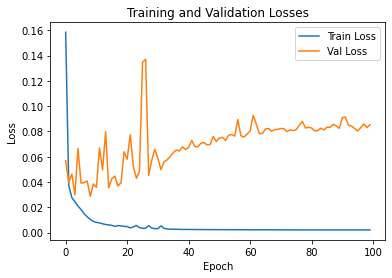

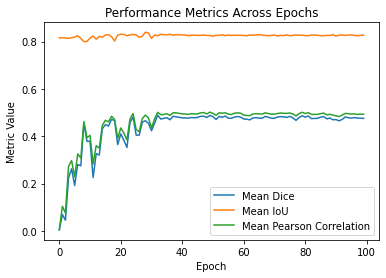

In [26]:


dev = "cuda" if torch.cuda.is_available() else "cpu"

model = UNetDeeplab(input_channel=3, output_channel=1).to(dev)
loss_function = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = lr_scheduler.StepLR(optimizer, step_size=num_epochs // 3, gamma=0.1)

train_losses = []
val_losses = []

mean_dice_scores = []
mean_iou_scores = []
mean_pearson_correlation = []

num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for batch_idx, (images, masks) in enumerate(train_loader):
        #print(f"Batch {batch_idx}, Input shape: {images.shape}")
        optimizer.zero_grad()
        outputs = model(images.to(dev))
        loss = loss_function(outputs, masks.to(dev))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_train_loss = total_loss / len(train_loader)
    train_losses.append(avg_train_loss)


    model.eval()
    total_val_loss = 0
    total_dice, total_iou, total_pearson = 0, 0, 0
    with torch.no_grad():
        for images, masks in test_loader:
            outputs = model(images.to(dev))
            val_loss = loss_function(outputs, masks.to(dev))
            total_val_loss += val_loss.item()
            
            outputs_thresh = torch.sigmoid(outputs) > 0.5
            total_dice += dice_coeff(outputs_thresh, masks.to(dev)).item()
            
            total_iou += iou(outputs_thresh, masks.to(dev)).mean().item()
            
            outputs_np = outputs_thresh.view(-1).cpu().numpy()
            masks_np = masks.view(-1).cpu().numpy()
            pearson_corr, _ = pearsonr(outputs_np, masks_np)
            if not np.isnan(pearson_corr):
                total_pearson += pearson_corr

    avg_val_loss = total_val_loss / len(test_loader)
    val_losses.append(avg_val_loss)

    avg_dice = total_dice / len(test_loader)
    mean_dice_scores.append(avg_dice)
    
    avg_iou = total_iou / len(test_loader)
    mean_iou_scores.append(avg_iou)
    
    avg_pearson = total_pearson / len(test_loader)
    mean_pearson_correlation.append(avg_pearson)

    scheduler.step()

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Mean Dice: {avg_dice:.4f}, Mean IoU: {avg_iou:.4f}, Pearson Correlation: {avg_pearson:.4f}')

torch.save(model.state_dict(), 'SE_filter_deeplab50_with_bce_loss_sched.pth')

plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.savefig('loss_plot.png')
plt.show()

plt.plot(mean_dice_scores, label='Mean Dice')
plt.plot(mean_iou_scores, label='Mean IoU')
plt.plot(mean_pearson_correlation, label='Mean Pearson Correlation')
plt.xlabel('Epoch')
plt.ylabel('Metric Value')
plt.title('Performance Metrics Across Epochs')
plt.legend()
plt.savefig('performance_metrics_plot.png')
plt.show()

7- Adagrad

Epoch 1/100, Train Loss: 0.3884, Val Loss: 0.3274, Mean Dice: 0.0004, Mean IoU: 0.6646, Pearson Correlation: -0.0103
Epoch 2/100, Train Loss: 0.2909, Val Loss: 0.2938, Mean Dice: 0.0008, Mean IoU: 0.7679, Pearson Correlation: -0.0037
Epoch 3/100, Train Loss: 0.2586, Val Loss: 0.2507, Mean Dice: 0.0006, Mean IoU: 0.7538, Pearson Correlation: -0.0058
Epoch 4/100, Train Loss: 0.2373, Val Loss: 0.2614, Mean Dice: 0.0008, Mean IoU: 0.7740, Pearson Correlation: -0.0035
Epoch 5/100, Train Loss: 0.2203, Val Loss: 0.2405, Mean Dice: 0.0008, Mean IoU: 0.7799, Pearson Correlation: -0.0033
Epoch 6/100, Train Loss: 0.2060, Val Loss: 0.1982, Mean Dice: 0.0008, Mean IoU: 0.7829, Pearson Correlation: -0.0036
Epoch 7/100, Train Loss: 0.1939, Val Loss: 0.2370, Mean Dice: 0.0009, Mean IoU: 0.8135, Pearson Correlation: -0.0002
Epoch 8/100, Train Loss: 0.1850, Val Loss: 0.1990, Mean Dice: 0.0010, Mean IoU: 0.8146, Pearson Correlation: -0.0000
Epoch 9/100, Train Loss: 0.1757, Val Loss: 0.1827, Mean Dice: 0.

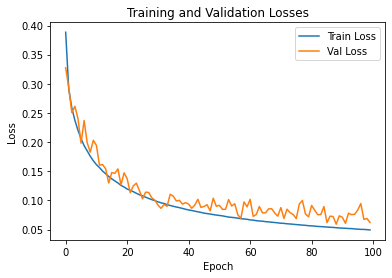

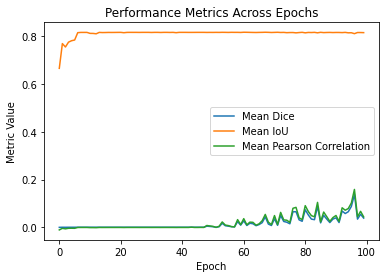

In [27]:


dev = "cuda" if torch.cuda.is_available() else "cpu"

model = UNetDeeplab(input_channel=3, output_channel=1).to(dev)
loss_function = nn.BCEWithLogitsLoss()
optimizer = optim.Adagrad(model.parameters(), lr=1e-4)

train_losses = []
val_losses = []

mean_dice_scores = []
mean_iou_scores = []
mean_pearson_correlation = []

num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for batch_idx, (images, masks) in enumerate(train_loader):
        #print(f"Batch {batch_idx}, Input shape: {images.shape}")
        optimizer.zero_grad()
        outputs = model(images.to(dev))
        loss = loss_function(outputs, masks.to(dev))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_train_loss = total_loss / len(train_loader)
    train_losses.append(avg_train_loss)


    model.eval()
    total_val_loss = 0
    total_dice, total_iou, total_pearson = 0, 0, 0
    with torch.no_grad():
        for images, masks in test_loader:
            outputs = model(images.to(dev))
            val_loss = loss_function(outputs, masks.to(dev))
            total_val_loss += val_loss.item()
            
            outputs_thresh = torch.sigmoid(outputs) > 0.5
            total_dice += dice_coeff(outputs_thresh, masks.to(dev)).item()
            
            total_iou += iou(outputs_thresh, masks.to(dev)).mean().item()
            
            outputs_np = outputs_thresh.view(-1).cpu().numpy()
            masks_np = masks.view(-1).cpu().numpy()
            pearson_corr, _ = pearsonr(outputs_np, masks_np)
            if not np.isnan(pearson_corr):
                total_pearson += pearson_corr

    avg_val_loss = total_val_loss / len(test_loader)
    val_losses.append(avg_val_loss)

    avg_dice = total_dice / len(test_loader)
    mean_dice_scores.append(avg_dice)
    
    avg_iou = total_iou / len(test_loader)
    mean_iou_scores.append(avg_iou)
    
    avg_pearson = total_pearson / len(test_loader)
    mean_pearson_correlation.append(avg_pearson)

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Mean Dice: {avg_dice:.4f}, Mean IoU: {avg_iou:.4f}, Pearson Correlation: {avg_pearson:.4f}')

torch.save(model.state_dict(), 'SE_filter_deeplab50_with_bce_loss_adagrad.pth')

plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.savefig('loss_plot.png')
plt.show()

plt.plot(mean_dice_scores, label='Mean Dice')
plt.plot(mean_iou_scores, label='Mean IoU')
plt.plot(mean_pearson_correlation, label='Mean Pearson Correlation')
plt.xlabel('Epoch')
plt.ylabel('Metric Value')
plt.title('Performance Metrics Across Epochs')
plt.legend()
plt.savefig('performance_metrics_plot.png')
plt.show()

8-  RM- SProp

Epoch 1/100, Train Loss: 0.0930, Val Loss: 0.0331, Mean Dice: 0.1847, Mean IoU: 0.8065, Pearson Correlation: 0.2303
Epoch 2/100, Train Loss: 0.0224, Val Loss: 0.0281, Mean Dice: 0.2669, Mean IoU: 0.8122, Pearson Correlation: 0.3081
Epoch 3/100, Train Loss: 0.0173, Val Loss: 0.0292, Mean Dice: 0.3602, Mean IoU: 0.8076, Pearson Correlation: 0.3875
Epoch 4/100, Train Loss: 0.0132, Val Loss: 0.0342, Mean Dice: 0.3916, Mean IoU: 0.8228, Pearson Correlation: 0.4236
Epoch 5/100, Train Loss: 0.0104, Val Loss: 0.0322, Mean Dice: 0.4603, Mean IoU: 0.7691, Pearson Correlation: 0.4681
Epoch 6/100, Train Loss: 0.0088, Val Loss: 0.0300, Mean Dice: 0.4563, Mean IoU: 0.8158, Pearson Correlation: 0.4693
Epoch 7/100, Train Loss: 0.0077, Val Loss: 0.2252, Mean Dice: 0.2011, Mean IoU: 0.8185, Pearson Correlation: 0.2524
Epoch 8/100, Train Loss: 0.0068, Val Loss: 0.0384, Mean Dice: 0.4219, Mean IoU: 0.8297, Pearson Correlation: 0.4511
Epoch 9/100, Train Loss: 0.0061, Val Loss: 0.0397, Mean Dice: 0.4317, Me

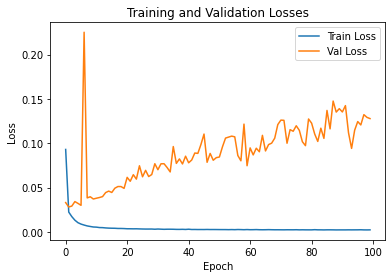

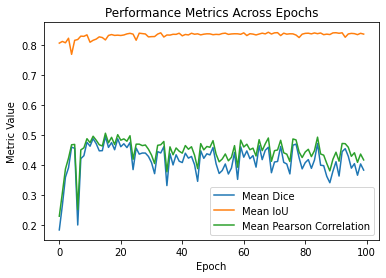

In [28]:

dev = "cuda" if torch.cuda.is_available() else "cpu"

model = UNetDeeplab(input_channel=3, output_channel=1).to(dev)
loss_function = nn.BCEWithLogitsLoss()
optimizer = optim.RMSprop(model.parameters(), lr=1e-4)

train_losses = []
val_losses = []

mean_dice_scores = []
mean_iou_scores = []
mean_pearson_correlation = []

num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for batch_idx, (images, masks) in enumerate(train_loader):
        #print(f"Batch {batch_idx}, Input shape: {images.shape}")
        optimizer.zero_grad()
        outputs = model(images.to(dev))
        loss = loss_function(outputs, masks.to(dev))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_train_loss = total_loss / len(train_loader)
    train_losses.append(avg_train_loss)


    model.eval()
    total_val_loss = 0
    total_dice, total_iou, total_pearson = 0, 0, 0
    with torch.no_grad():
        for images, masks in test_loader:
            outputs = model(images.to(dev))
            val_loss = loss_function(outputs, masks.to(dev))
            total_val_loss += val_loss.item()
            
            outputs_thresh = torch.sigmoid(outputs) > 0.5
            total_dice += dice_coeff(outputs_thresh, masks.to(dev)).item()
            
            total_iou += iou(outputs_thresh, masks.to(dev)).mean().item()
            
            outputs_np = outputs_thresh.view(-1).cpu().numpy()
            masks_np = masks.view(-1).cpu().numpy()
            pearson_corr, _ = pearsonr(outputs_np, masks_np)
            if not np.isnan(pearson_corr):
                total_pearson += pearson_corr

    avg_val_loss = total_val_loss / len(test_loader)
    val_losses.append(avg_val_loss)

    avg_dice = total_dice / len(test_loader)
    mean_dice_scores.append(avg_dice)
    
    avg_iou = total_iou / len(test_loader)
    mean_iou_scores.append(avg_iou)
    
    avg_pearson = total_pearson / len(test_loader)
    mean_pearson_correlation.append(avg_pearson)

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Mean Dice: {avg_dice:.4f}, Mean IoU: {avg_iou:.4f}, Pearson Correlation: {avg_pearson:.4f}')

torch.save(model.state_dict(), 'SE_filter_deeplab50_with_bce_loss_rmsprop.pth')

plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.savefig('loss_plot.png')
plt.show()

plt.plot(mean_dice_scores, label='Mean Dice')
plt.plot(mean_iou_scores, label='Mean IoU')
plt.plot(mean_pearson_correlation, label='Mean Pearson Correlation')
plt.xlabel('Epoch')
plt.ylabel('Metric Value')
plt.title('Performance Metrics Across Epochs')
plt.legend()
plt.savefig('performance_metrics_plot.png')
plt.show()